# Fast Directional Radiosity

This examples shows a simple diffuse simulation of a shoebox room and compare the the result with the analytical solution.
First we import all our dependencies.

In [27]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparrowpy as sp
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib ipympl

declare ir generation function

In [28]:
def gen_noise_seq(
    room_volume,
    duration=1.,
    out_sr=44100,
    speed_of_sound = 343.26,
) -> pf.Signal:
    """
    Calculate the noise sequence signal for IR generation.

    Parameters
    ----------
    room_volume : float/int
        Volume through X*Y*Z of the room.
    duration : float
        desired duration of the noise sequence
        (usually same duration as IR)
    out_sr : float
        Output sampling rate.
    speed_of_sound : flaot
        Speed of sound

    Returns
    -------
    noise_signal : pf.Signal
        Noise sequence for IR generation.
    """
    time_step = 1 / out_sr

    # noise sequence with poisson distribution
    rng = np.random.default_rng()
    diracNonZeros = []
    µ_t = (
        4 * np.pi * pow(speed_of_sound, 3) / room_volume
    )

    for t_sample in np.arange(1/out_sr, duration, time_step):
        time_for_itr = t_sample
        while (
            delta := (
                1
                / (min(µ_t * pow(t_sample, 2), 10000))
                * np.log(1 / rng.uniform(1e-10, 1))
            )
        ) < time_for_itr + time_step - t_sample:
            t_sample += delta
            diracNonZeros.append(rng.choice([-t_sample, t_sample],
                                            p=[0.5, 0.5]))

    dirac_times = np.arange(0, duration, time_step)
    dirac_values = np.zeros_like(dirac_times)
    for t_sample in diracNonZeros:
        ix = int(abs(t_sample) / time_step)
        if dirac_values[ix] == 0:
            dirac_values[ix] = np.sign(t_sample)

    noise_signal = pf.Signal(dirac_values, out_sr)

    return noise_signal

In [ ]:
def gen_ir(
    etc: pf.TimeData,
    noise_signal: pf.Signal,
    freq_bands=[1000],
) -> pf.Signal:
    """
    Generate the impulse response for a given ETC.

    Parameters
    ----------
    etc: pf.TimeData
        ETC of a soudn propagation simulation.
    noise_signal: pf.Signal
        Noise sequence

    Returns
    -------
    ir : pf.Signal
        Dirac impulse response of the room.
    """

    factor_s = noise_signal.sampling_rate*(etc.times[1]-etc.times[0])

    band_filtered_noise = pf.dsp.filter.fractional_octave_bands(
        signal=noise_signal,
        num_fractions=1,
        order=4,
    )
    center_freq = pf.dsp.filter.fractional_octave_frequencies(
        num_fractions=1,
    )


    pf.plot.freq(
        pf.Signal(band_filtered_noise.time, noise_signal.sampling_rate),
    )
    plt.show()

    weighted_noise = np.zeros(
        (
            band_filtered_noise.time.shape[0],
            band_filtered_noise.time.shape[2],
        ),
    )
    bw_size = [
        center_freq[1][i] * np.sqrt(2) - center_freq[1][i] / np.sqrt(2)
        for i in range(len(center_freq[1]))
    ]


    for etc_ix,fband in enumerate(freq_bands):
        for i,f in enumerate(center_freq[0]):
            if f == fband:
                filter_ix=i
                for sample_i in range(etc.time.shape[-1]):
                    low = int(sample_i * factor_s)
                    high = (
                        int(sample_i * factor_s + factor_s) - 1
                    )
                    div = sum(band_filtered_noise.time[filter_ix, 0, low:high] ** 2)
                    if div != 0:
                        weighted_noise[filter_ix, low:high] = (
                            band_filtered_noise.time[filter_ix, 0, low:high]
                            * np.sqrt(etc.time[0,etc_ix,sample_i] / div)
                            * np.sqrt(bw_size[filter_ix] / (noise_signal.sampling_rate/2))
                        )
                    else:
                        weighted_noise[filter_ix, low:high] = np.zeros((high-low,))
                break

    ir = pf.Signal(np.sum(weighted_noise, axis=0),
                               noise_signal.sampling_rate)

    return ir

Lets define our room and source position.

In [30]:
# Define parameters
X = 5
Y = 6
Z = 4
patch_size = 1
etc_duration = 1
etc_time_resolution = 1/500
max_reflection_order = 150
speed_of_sound = 343.2
absorption = 0.1

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source = pf.Coordinates(2, 2, 2)
receiver = pf.Coordinates(2, 3, 2)

radi = sp.DirectionalRadiosityFast.from_polygon(walls, patch_size)

In [31]:
# create directional scattering data (totally diffuse)
brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)
frequencies = pf.dsp.filter.fractional_octave_frequencies(
                        num_fractions=1,
                        frequency_range=(125, 16000))[0]
brdf = sp.brdf.create_from_scattering(
    brdf_sources,
    brdf_receivers,
    pf.FrequencyData(np.ones_like(frequencies), frequencies),
    pf.FrequencyData(absorption*np.ones_like(frequencies), frequencies))

# set directional scattering data
radi.set_wall_brdf(
    np.arange(len(walls)), brdf, brdf_sources, brdf_receivers)

radi.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(brdf.frequencies),
        brdf.frequencies))

C:\Users\WS2080-01\AppData\Local\Temp\ipykernel_12184\1362516340.py:14: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radi.set_wall_brdf(


In [32]:
radi.bake_geometry()
radi.init_source_energy(source)
radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=etc_time_resolution,
        etc_duration=etc_duration,
        max_reflection_order=max_reflection_order)
etc_radiosity = radi.collect_energy_receiver_mono(
    receivers=receiver)

let's make this mono IR

<Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

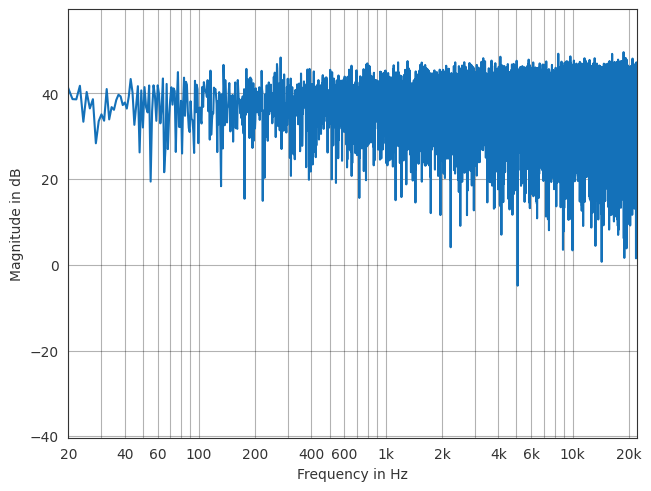

In [33]:
noise_seq = gen_noise_seq(
                room_volume=4*5*6,
                duration=etc_radiosity.times[-1],
                )
pf.plot.freq(noise_seq)

now we gotta weight each band-etc by the band-filtered noise and add those 2gether

d:\Joao_Fatela\dev\sparrowpy\.venv\Lib\site-packages\pyfar\dsp\filter\fractional_octaves.py:252: UserWarning: The upper frequency limit 22387.2 Hz is above the Nyquist frequency. Using a highpass filter instead of a bandpass.
  sos = _coefficients_fractional_octave_bands(


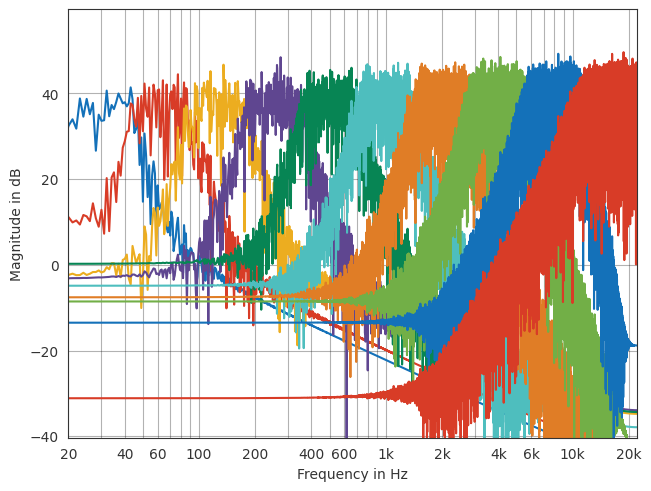

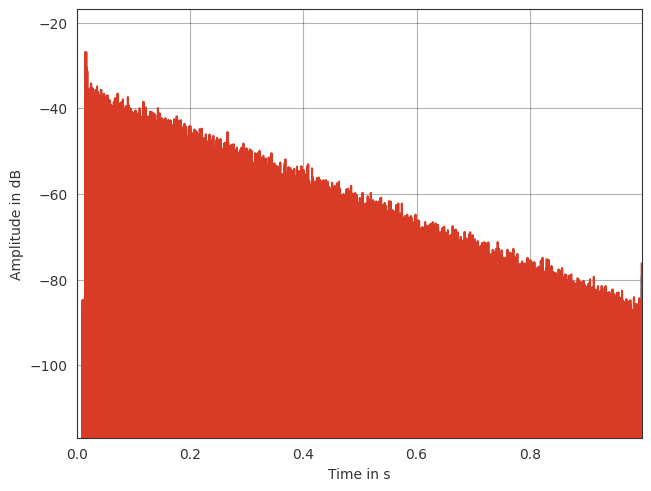

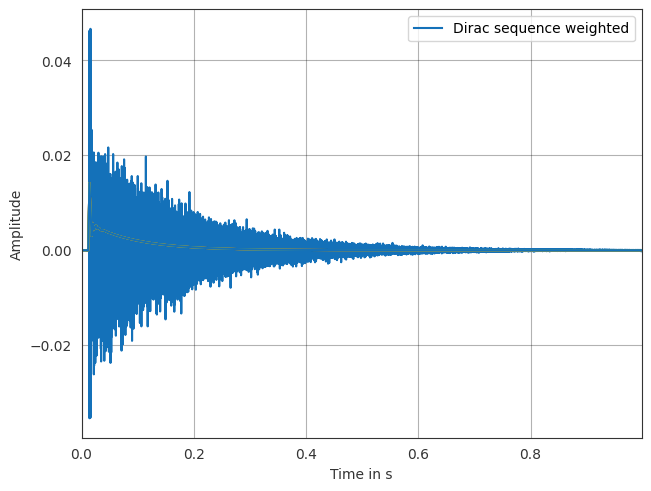

In [44]:
IR = gen_ir(etc=etc_radiosity,
            noise_signal=noise_seq,
            freq_bands=frequencies)